In [172]:
import numpy as np
import seaborn as sns #визуализация ... связано с pandas, надстройка над plt
import matplotlib.pyplot as plt
import pandas as pd # основная работа с df

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [173]:
events = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip")
subm = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip")
subm.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [174]:
events.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


# Обучение Дерева решений на первых 3х днях 
обучения учеников Степика, предсказание, кто уйдет

## Предобработка, чтобы узнать, кто ушел, кто закончил курс

In [175]:
events.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [176]:
#создадим колонку - окончил курс, которая значит "баллов больше 100"
# практические шаги
scores_pract_correct = subm[subm.submission_status == 'correct'].groupby('user_id') \
                                  .submission_status.count() \
                                  .sort_values(ascending = False) \
                                  .fillna(0)

scores_pract_wr = subm[subm.submission_status == 'wrong'].groupby('user_id') \
                                  .submission_status.count() \
                                  .sort_values(ascending = False)

# соотношение верных практических ко всем практическим шагам
scores_pract_ratio = scores_pract_correct / (scores_pract_correct + scores_pract_wr)

# теоретические шаги
scores_theor_pass = events[events.action == 'passed'].groupby('user_id') \
                                  .action.count() \
                                  .sort_values(ascending = False) 
                                
scores_theor_view = events[events.action == 'viewed'] \
                                  .groupby('user_id') \
                                  .action.count() \
                                  .sort_values(ascending = False)
scores_theor_start = events[events.action == 'started_attempt'] \
                                  .groupby('user_id') \
                                  .action.count().sort_values(ascending = False)
scores_theor_discover = events[events.action == 'discovered'] \
                                  .groupby('user_id').action.count() \
                                  .sort_values(ascending = False)

# соотношение верных теоретических ко всем теоретическим шагам
scores_theor_ratio = scores_theor_pass / (scores_theor_pass + \
                                          scores_theor_view + \
                                          scores_theor_start + \
                                          scores_theor_discover)



# общая сумма правильных шагов
scores = (scores_theor_pass + scores_pract_correct).fillna(0).map(int)

scores = pd.DataFrame({'scores': scores, \
                       'scores_theor_pass': scores_theor_pass, \
                       'scores_theor_view': scores_theor_view, \
                       'scores_theor_start': scores_theor_start, \
                       'scores_theor_discover': scores_theor_discover, \
                       'scores_pract_correct': scores_pract_correct,
                       'scores_pract_ratio': scores_pract_ratio, \
                       'scores_theor_ratio': scores_theor_ratio}) \
                       .fillna(0) \
                       .reset_index() \
                       .astype({'scores_theor_pass': 'int32', \
                                'scores_theor_view': 'int32', \
                                'scores_theor_start': 'int32', \
                                'scores_theor_discover': 'int32',\
                                'scores_pract_correct': 'int32', \
                                'scores': 'int32'})

scores['passed_course'] = np.where((scores.scores >= 100), True, False)
scores

,user_id,scores,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio,passed_course
0,1,0,0,1,0,1,0,0.000000,0.000000,False
1,2,11,9,10,2,9,2,0.000000,0.300000,False
2,3,116,87,192,30,91,29,0.557692,0.217500,True
3,5,13,11,12,4,11,2,0.500000,0.289474,False
4,7,0,1,1,0,1,0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
19229,26790,9,8,9,1,8,1,0.000000,0.307692,False
19230,26793,0,0,1,1,1,0,0.000000,0.000000,False
19231,26794,102,69,180,34,69,33,0.785714,0.196023,True
19232,26797,12,10,13,2,10,2,0.000000,0.285714,False


In [177]:
# проверка на количество user_id в обоих датасетах 
# = 19234 (это радует, тк в датасете times их столько же)
pd.concat([subm.user_id, events.user_id]).nunique()

19234

In [178]:
#создадим колонку - ушел, которая значит "не появлялся на курсе 2 месяца"
# практические шаги
time_pract = subm.groupby('user_id').timestamp.last()
# теоретические шаги
time_theor = events.groupby('user_id').timestamp.last()

# время изъятия данных, запишем в переменную threshold в микросекундах время изъятия данных
# и будем всех не прошедших курс сравнивать с ним, если (граница - их последнее появление) > 2 месяцев,
# то убыли. Если меньше - в процессе. Если прошли, то им ставим False автоматом 
if events['timestamp'].max() > subm['timestamp'].max():
  threshold = events['timestamp'].max()
else:
  threshold = subm['timestamp'].max()
print('threshold = ', threshold / (60*60*24*12*365) )

two_months = 60*60*24*2

times = pd.DataFrame({'time_pract':time_pract, 'time_theor':time_theor}).fillna(0).astype(int)
times['gone'] = np.where((threshold - times[['time_pract', 'time_theor']].max(axis=1)) > two_months, True, False)

print('соотношение бросивших курс = ', 100*(times[times.gone == False].gone.count() / times.shape[0]), '%')
times.reset_index()
#time_pract.merge(time_theor)

threshold =  4.034470686939794
соотношение бросивших курс =  1.0658209420817304 %


,user_id,time_pract,time_theor,gone
0,1,0,1472827464,True
1,2,1514383420,1519226966,True
2,3,1444568820,1444581588,True
3,5,1499859650,1499859939,True
4,7,0,1521634660,True
...,...,...,...,...
19229,26790,1451722691,1517495987,True
19230,26793,0,1510225034,True
19231,26794,1495290798,1512035039,True
19232,26797,1508425367,1509995096,True


In [179]:
stud = scores.merge(times, on = 'user_id', how = 'outer').fillna(0).astype(int)
stud

,user_id,scores,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio,passed_course,time_pract,time_theor,gone
0,1,0,0,1,0,1,0,0,0,0,0,1472827464,1
1,2,11,9,10,2,9,2,0,0,0,1514383420,1519226966,1
2,3,116,87,192,30,91,29,0,0,1,1444568820,1444581588,1
3,5,13,11,12,4,11,2,0,0,0,1499859650,1499859939,1
4,7,0,1,1,0,1,0,0,0,0,0,1521634660,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,9,8,9,1,8,1,0,0,0,1451722691,1517495987,1
19230,26793,0,0,1,1,1,0,0,0,0,0,1510225034,1
19231,26794,102,69,180,34,69,33,0,0,1,1495290798,1512035039,1
19232,26797,12,10,13,2,10,2,0,0,0,1508425367,1509995096,1


In [180]:
print("процент прошедших курс = ", (stud[stud.passed_course == 1].scores.count() / stud.shape[0])*100, "%")

процент прошедших курс =  15.217843402308413 %


In [181]:
# выкинем из датасета тех, кто не ушел (gone = 0) и не закончил (passed_course = 0) (их около 200)
stud_new = stud[~((stud.passed_course == 0) & (stud.gone == 0))].drop(['gone'], axis=1)
print("процент прошедших курс = ", (stud_new[stud_new.passed_course == 1].scores.count() / stud_new.shape[0])*100, "%")
stud_new

процент прошедших курс =  15.331831753182126 %


,user_id,scores,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio,passed_course,time_pract,time_theor
0,1,0,0,1,0,1,0,0,0,0,0,1472827464
1,2,11,9,10,2,9,2,0,0,0,1514383420,1519226966
2,3,116,87,192,30,91,29,0,0,1,1444568820,1444581588
3,5,13,11,12,4,11,2,0,0,0,1499859650,1499859939
4,7,0,1,1,0,1,0,0,0,0,0,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,9,8,9,1,8,1,0,0,0,1451722691,1517495987
19230,26793,0,0,1,1,1,0,0,0,0,0,1510225034
19231,26794,102,69,180,34,69,33,0,0,1,1495290798,1512035039
19232,26797,12,10,13,2,10,2,0,0,0,1508425367,1509995096


## Посмотрим результаты обучения ДР на всей выборке за три года
сначала, а потом попробуем предсказать на основе первых трех дней

In [182]:
clf = tree.DecisionTreeClassifier()

params = {'criterion': ['entropy'], 
          'max_depth': range(1,20),
          'min_samples_split': range(2,100), 
          'min_samples_leaf': range(2,100),
          'min_impurity_decrease': [0 + i/100 for i in range(1, 75)]
          }
params_simple = {'criterion': ['entropy'], 
          'max_depth': range(1,20) }
#auto_clf = RandomizedSearchCV(clf, params, scoring = make_scorer(roc_auc_score), cv = 5)
auto_clf = GridSearchCV(clf, params_simple, scoring = make_scorer(roc_auc_score), cv = 5)

In [183]:
X = stud_new.drop(['passed_course', 'scores'], axis=1)
y = stud_new['passed_course']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

auto_clf.fit(X_train, y_train)
#auto_clf.fit(X, y)
auto_clf.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [184]:
new_clf = auto_clf.best_estimator_
y_predicted = new_clf.predict(X_test)

#roc_auc_score(y_true = y_test, y_score= new_clf.decision_function(X_test))
print('precision_test = ', precision_score(y_true = y_test, y_pred = y_predicted, average = 'micro'))
print('recall_test = ', recall_score(y_true = y_test, y_pred = y_predicted, average = 'micro'))

print('best score roc_auc = ',auto_clf.best_score_)
# поскольку я убрала из 3годового датасета разбиение по разным баллам, метрики упали на 10 показателей и дерево сильно длинное

precision_test =  0.9984129503253452
recall_test =  0.9984129503253452
best score roc_auc =  0.9978334417156706


##Предскажем по 3 дням Деревом решений

In [185]:
# для каждого пользователя сделаем значение в микросекундах - его первые три дня на курсе
# для начала = 10 октября 00:00, граница = 13 октября 00:00 например
first3days = events.groupby("user_id") \
            .agg({"timestamp" : lambda x: x.min() + 3 * 24 * 60 * 60}) \
            .reset_index().rename({"timestamp" : "first3days"}, axis=1)

# events примёрдживаем к получившемуся DataFrame и берем только те строки в которых не нарушен лимит
# получаем тот же датасет, только все пользователи обрезаны тремя днями их деятельности
events_train = events.merge(first3days, how="outer").query("timestamp <= first3days")
events_not_need = events.merge(first3days, how="outer").query("timestamp > first3days")

events_train

# также фильтруем значения для submitов
first3days = subm.groupby("user_id") \
            .agg({"timestamp" : lambda x: x.min() + 3 * 24 * 60 * 60}) \
            .reset_index().rename({"timestamp" : "first3days"}, axis=1)

subm_train = subm.merge(first3days, how="outer").query("timestamp <= first3days")
subm_not_need = subm.merge(first3days, how="outer").query("timestamp > first3days")

subm_train

,step_id,timestamp,submission_status,user_id,first3days
0,31971,1434349275,correct,15853,1434605256
1,31972,1434348300,correct,15853,1434605256
4,31976,1434348123,wrong,15853,1434605256
5,31976,1434348188,correct,15853,1434605256
7,31977,1434347371,correct,15853,1434605256
...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,1502206159
509100,120745,1503059927,correct,13177,1503319127
509101,120745,1506348153,wrong,15253,1506607353
509102,120745,1523035316,wrong,1424,1523294516


In [186]:
# проверка на ничего не потеряли
print(subm_train.shape[0] + subm_not_need.shape[0] == subm.shape[0])
events_train.shape[0] + events_not_need.shape[0] == 2465718 + 1014985 == events.shape[0]

True


True

In [187]:
# практические шаги
scores_pract_correct = subm_train[subm_train.submission_status == 'correct'].groupby('user_id') \
                                  .submission_status.count() \
                                  .sort_values(ascending = False) \
                                  .fillna(0)

scores_pract_wr = subm_train[subm_train.submission_status == 'wrong'].groupby('user_id') \
                                  .submission_status.count() \
                                  .sort_values(ascending = False)

# соотношение верных практических ко всем практическим шагам
scores_pract_ratio = scores_pract_correct / (scores_pract_correct + scores_pract_wr)

# теоретические шаги
scores_theor_pass = events[events.action == 'passed'].groupby('user_id') \
                                  .action.count() \
                                  .sort_values(ascending = False) 
                                
scores_theor_view = events[events.action == 'viewed'] \
                                  .groupby('user_id') \
                                  .action.count() \
                                  .sort_values(ascending = False)
scores_theor_start = events[events.action == 'started_attempt'] \
                                  .groupby('user_id') \
                                  .action.count().sort_values(ascending = False)
scores_theor_discover = events[events.action == 'discovered'] \
                                  .groupby('user_id').action.count() \
                                  .sort_values(ascending = False)

# соотношение верных теоретических ко всем теоретическим шагам
scores_theor_ratio = scores_theor_pass / (scores_theor_pass + \
                                          scores_theor_view + \
                                          scores_theor_start + \
                                          scores_theor_discover)

scores = pd.DataFrame({'scores_theor_pass': scores_theor_pass, \
                       'scores_theor_view': scores_theor_view, \
                       'scores_theor_start': scores_theor_start, \
                       'scores_theor_discover': scores_theor_discover, \
                       'scores_pract_correct': scores_pract_correct,
                       'scores_pract_ratio': scores_pract_ratio, \
                       'scores_theor_ratio': scores_theor_ratio}) \
                       .fillna(0) \
                       .reset_index() \
                       .astype({'scores_theor_pass': 'int32', \
                                'scores_theor_view': 'int32', \
                                'scores_theor_start': 'int32', \
                                'scores_theor_discover': 'int32',\
                                'scores_pract_correct': 'int32'})

#scores['passed_course'] = np.where((scores.scores >= 100), True, False)
#events.merge(scores.rename('scores'), on = 'user_id', left_index=True, right_index=True)
scores

,user_id,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio
0,1,0,1,0,1,0,0.000000,0.000000
1,2,9,10,2,9,2,0.000000,0.300000
2,3,87,192,30,91,4,0.500000,0.217500
3,5,11,12,4,11,2,0.500000,0.289474
4,7,1,1,0,1,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
19229,26790,8,9,1,8,1,0.000000,0.307692
19230,26793,0,1,1,1,0,0.000000,0.000000
19231,26794,69,180,34,69,31,0.775000,0.196023
19232,26797,10,13,2,10,2,0.000000,0.285714


In [188]:
# практические шаги
time_pract = subm.groupby('user_id').timestamp.last()
# теоретические шаги
time_theor = events.groupby('user_id').timestamp.last()

times = pd.DataFrame({'time_pract':time_pract, 'time_theor':time_theor}).fillna(0).astype(int)
times.reset_index()

,user_id,time_pract,time_theor
0,1,0,1472827464
1,2,1514383420,1519226966
2,3,1444568820,1444581588
3,5,1499859650,1499859939
4,7,0,1521634660
...,...,...,...
19229,26790,1451722691,1517495987
19230,26793,0,1510225034
19231,26794,1495290798,1512035039
19232,26797,1508425367,1509995096


In [189]:
stud_3days = scores.merge(times, on = 'user_id', how = 'outer').fillna(0) #.astype(int)
stud_3days

,user_id,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio,time_pract,time_theor
0,1,0,1,0,1,0,0.000000,0.000000,0,1472827464
1,2,9,10,2,9,2,0.000000,0.300000,1514383420,1519226966
2,3,87,192,30,91,4,0.500000,0.217500,1444568820,1444581588
3,5,11,12,4,11,2,0.500000,0.289474,1499859650,1499859939
4,7,1,1,0,1,0,0.000000,0.000000,0,1521634660
...,...,...,...,...,...,...,...,...,...,...
19229,26790,8,9,1,8,1,0.000000,0.307692,1451722691,1517495987
19230,26793,0,1,1,1,0,0.000000,0.000000,0,1510225034
19231,26794,69,180,34,69,31,0.775000,0.196023,1495290798,1512035039
19232,26797,10,13,2,10,2,0.000000,0.285714,1508425367,1509995096


In [190]:
# те user_id, кто не ушел (gone = 0) и не закончил (passed_course = 0) (их около 200)
stud_in_process = stud[(stud.passed_course == 0) & (stud.gone == 0)].user_id

# удалим тех, кто в процессе и из 3х дневного датасета тоже
stud_3days_1 = stud_3days[~stud_3days.user_id.isin(stud_in_process)].dropna()
#stud_3days_1 = stud_3days.merge(stud_in_process, on = 'user_id', how='left')
stud_3days_1

,user_id,scores_theor_pass,scores_theor_view,scores_theor_start,scores_theor_discover,scores_pract_correct,scores_pract_ratio,scores_theor_ratio,time_pract,time_theor
0,1,0,1,0,1,0,0.000000,0.000000,0,1472827464
1,2,9,10,2,9,2,0.000000,0.300000,1514383420,1519226966
2,3,87,192,30,91,4,0.500000,0.217500,1444568820,1444581588
3,5,11,12,4,11,2,0.500000,0.289474,1499859650,1499859939
4,7,1,1,0,1,0,0.000000,0.000000,0,1521634660
...,...,...,...,...,...,...,...,...,...,...
19229,26790,8,9,1,8,1,0.000000,0.307692,1451722691,1517495987
19230,26793,0,1,1,1,0,0.000000,0.000000,0,1510225034
19231,26794,69,180,34,69,31,0.775000,0.196023,1495290798,1512035039
19232,26797,10,13,2,10,2,0.000000,0.285714,1508425367,1509995096


## Обучение: Берем Y из выборки по всему времени, а Х из 3х дней

In [191]:
X = stud_3days_1
y = stud_new['passed_course']

X.to_csv('shortX.csv')
y.to_csv('shorty.csv')


# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0) 
# ПОТОМ НАДО СДЕЛАТЬ ВЫРАВНИВАНИЕ ПЕРЕКОШЕННЫХ КЛАССОВ (не надо, см дальше)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

In [192]:
print('перекос в teste', y_test[y_test == 0].count() / y_test.shape[0])
print('перекос в traine', y_train[y_train == 0].count() / y_train.shape[0])
print('очень похожи, так что это где-то встроено. в train_test_split, вероятно')

перекос в teste 0.8446278368512935
перекос в traine 0.8476935105551212
очень похожи, так что это где-то встроено. в train_test_split, вероятно


In [210]:
clf = tree.DecisionTreeClassifier()

params = {'criterion': ['entropy'], 
          'max_depth': range(1,20),
          'min_samples_split': range(2,100), 
          'min_samples_leaf': range(2,100),
          'min_impurity_decrease': [0 + i/100 for i in range(1, 75)]
          }

params_simple = {'criterion': ['entropy'], 'min_samples_split': range(50,300,20), 
                 'min_samples_leaf': range(100,200,50),
                 'max_depth': range(1,10)}
#auto_clf = RandomizedSearchCV(clf, params, scoring = make_scorer(roc_auc_score), cv = 5)
auto_clf = GridSearchCV(clf, params_simple, scoring = make_scorer(roc_auc_score), cv = 5)

In [211]:
auto_clf.fit(X_train, y_train)
auto_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 100,
 'min_samples_split': 50}

In [212]:
new_clf = auto_clf.best_estimator_
y_predicted = new_clf.predict(X_test)

#roc_auc_score(y_true = y_test, y_score= new_clf.decision_function(X_test))
print('precision_test = ', precision_score(y_true = y_test, y_pred = y_predicted, average = 'micro'))
print('recall_test = ', recall_score(y_true = y_test, y_pred = y_predicted, average = 'micro'))

print('best score roc_auc = ',auto_clf.best_score_)

precision_test =  0.9901602920171402
recall_test =  0.9901602920171402
best score roc_auc =  0.9889399939573013


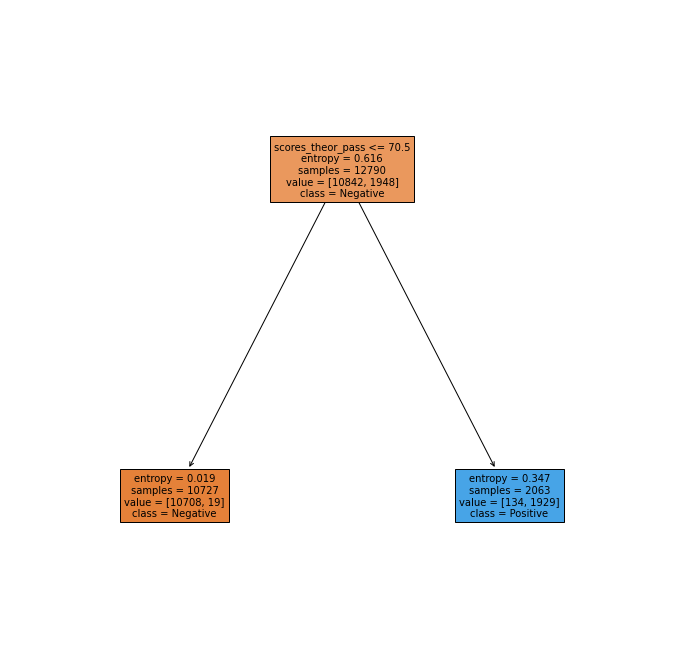

In [214]:

plt.figure(figsize=(12,12))  # set plot size (denoted in inches)

tree.plot_tree(new_clf, 
                   feature_names= list(X),  
                   class_names= ['Negative','Positive'],
                   filled=True,
                   fontsize=10)
plt.show()